In [193]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:
# package imports
import numpy as np
import operator
import argparse
import os

# plot-specific imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
# import seaborn as sns

# user-defined imports
import utils
from utils_plot import Args
import utils_plot as putils
import baselines

In [207]:
def qualitative_plot_ranked(dataloader, RECONSTRUCTIONS, METRICS, args, variance, num_measurements, save_dpath=None):
    ## assume variance/num_measurements are fixed
    NROWS = len(RECONSTRUCTIONS) + 1 #+1 for original images
    NCOLS = len(dataloader)
    
    psnr_precision = 2
    mse_precision = 4
    
    fig, ax = plt.subplots(NROWS, NCOLS)
#     fig.set_size_inches(NROWS*2, NCOLS*2, forward=True)

    ## Row 0: Original Images
    putils.set_axes("Original", ax[0, 0])
    for k, (batch, _ , im_path) in enumerate(dataloader):
        putils.plot_image(batch, args, flag='orig', axis_dict=dict(axis=ax[0,k], label=None))

    ## Row 1 - Row num_algorithms: each algorithm
    max_per_col = [0] * NCOLS
    metrics_matrix = []
    for i, ALG in enumerate(sorted(RECONSTRUCTIONS)):
        metrics_row = []
        for k, image in enumerate(RECONSTRUCTIONS[ALG][num_measurements][variance]):
            mse = METRICS['MSE'][ALG][num_measurements][variance][k]
            psnr = METRICS['PSNR'][ALG][num_measurements][variance][k]
            max_per_col[k] = max(max_per_col[k], psnr)
            metrics_row.append((mse, psnr))
        metrics_matrix.append(metrics_row)
    
    metrics_matrix = np.array(metrics_matrix)
    for i, ALG in enumerate(sorted(RECONSTRUCTIONS)):
        args.ALG = ALG
        putils.set_axes(ALG, ax[i+1, 0])
        for k, image in enumerate(RECONSTRUCTIONS[ALG][num_measurements][variance]):
            mse, psnr = metrics_matrix[i][k]
            psnr_sorted = sorted(list(metrics_matrix[:, k, 1].squeeze()), reverse=True)
            bold = psnr_sorted.index(psnr) == 0
            underline = psnr_sorted.index(psnr) == 1
            # label = f"MSE: {round(mse, mse_precision)}\nPSNR: {round(psnr, psnr_precision)}"
            label = f"PSNR: {round(psnr, psnr_precision)}"
            putils.plot_image(image, args, flag='recons', axis_dict=dict(axis=ax[i+1,k], label=label, bold=bold, underline=underline))
    
    # https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=0.9, 
                        top=0.9, 
                        wspace=1, # The width of the padding between subplots, as a fraction of the average Axes width.
                        hspace=1) # The height of the padding between subplots, as a fraction of the average Axes height
    plt.suptitle(f"$\sigma^2={variance}$\nnum_measurements={num_measurements}", y=1.1) 
    if save_dpath is not None and os.path.isdir(save_dpath):
        plt.savefig(os.path.join(save_dpath, f"retino_{variance}var_{num_measurements}meas.png"), bbox_inches='tight')
    else:
        plt.show()

def qualitative_plot(dataloader, RECONSTRUCTIONS, METRICS, args, variance, num_measurements):
    ## assume variance/num_measurements are fixed
    NROWS = len(RECONSTRUCTIONS) + 2 #+2 for original images + compressed image
    NCOLS = len(dataloader)
    
    psnr_precision = 2
    mse_precision = 4
    
    fig, ax = plt.subplots(NROWS, NCOLS)
#     fig.set_size_inches(NROWS*2, NCOLS*2, forward=True)

    ## Row 0: Original Images
    putils.set_axes("Original", ax[0, 0])
    for k, (batch, _ , im_path) in enumerate(dataloader):
        putils.plot_image(batch, args, flag='orig', axis_dict=dict(axis=ax[0,k], label=None))

    ## Row 1 - Row num_algorithms: each algorithm
    max_per_col = [0] * NCOLS
    metrics_matrix = []
    for i, ALG in enumerate(sorted(RECONSTRUCTIONS)):
        metrics_row = []
        for k, image in enumerate(RECONSTRUCTIONS[ALG][num_measurements][variance]):
            mse = METRICS['MSE'][ALG][num_measurements][variance][k]
            psnr = METRICS['PSNR'][ALG][num_measurements][variance][k]
            max_per_col[k] = max(max_per_col[k], psnr)
            metrics_row.append((mse, psnr))
        metrics_matrix.append(metrics_row)
    
    metrics_matrix = np.array(metrics_matrix)
    for i, ALG in enumerate(sorted(RECONSTRUCTIONS)):
        args.ALG = ALG
        putils.set_axes(ALG, ax[i+1, 0])
        for k, image in enumerate(RECONSTRUCTIONS[ALG][num_measurements][variance]):
            mse, psnr = metrics_matrix[i][k]
#             psnr_sorted = sorted(list(metrics_matrix[:, k, 1].squeeze()), reverse=True)
#             bold = psnr_sorted.index(psnr) == 0
#             underline = psnr_sorted.index(psnr) == 1
            label = f"MSE: {round(mse, mse_precision)}\nPSNR: {round(psnr, psnr_precision)}"
#             label = f"PSNR: {round(psnr, psnr_precision)}"
            putils.plot_image(image, args, flag='recons', axis_dict=dict(axis=ax[i+1,k], label=label))
    
    # https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
    plt.subplots_adjust(left=0,
                        bottom=0, 
                        right=0.9, 
                        top=0.9, 
                        wspace=1, # The width of the padding between subplots, as a fraction of the average Axes width.
                        hspace=1) # The height of the padding between subplots, as a fraction of the average Axes height
    plt.suptitle(f"$\sigma^2={variance}$\nnum_measurements={num_measurements}", y=1.1) 
    plt.show()

In [196]:
from collections import defaultdict
import matplotlib
def plot_metric_vs_nmeas(args, metric, variance):
    plt.suptitle(f"{metric} vs num measurements\n$\sigma^2={variance}$")
    
    # convert to d[alg][meas] = [list of values]
    max_value = 0
    min_value = float("inf")
    dictionary = defaultdict(dict)
    for alg in METRICS[metric]:
        for meas in METRICS[metric][alg]:
            dictionary[alg][meas] = METRICS[metric][alg][meas][variance]
            max_value = max(max_value, np.amax(dictionary[alg][meas]))
            min_value = min(min_value, np.amin(dictionary[alg][meas]))
            
    # Plot MSE of each algorithm
    KWARGS_DICT = putils.set_kwargs(args.DATASET)
    for ALG in dictionary:
        kwargs = KWARGS_DICT[ALG]
        putils.plot_mse(dictionary[ALG], args, kwargs)

    Y_LIM = 0.005 # set max value on vertical axis 
    Y_LIM = 1.05 * max_value
    args.xlabel="num measurements"
    args.ylabel=metric
    args.xticks = list(dictionary[list(dictionary.keys())[0]].keys())
    Y_MIN = 0 if metric == "MSE" else 0.98 * min_value
    Y_MAX = 1.05 * max_value
    putils.plot_format(Y_MIN, Y_MAX, args) # set labels, limits, ticks, legend in plot
    plt.tight_layout()
    plt.show()

def plot_metric_vs_variance(args, metric, num_measurements):
    plt.suptitle(f"{metric} vs variance $\sigma^2$\n num_measurements={num_measurements}")
    
    # convert to d[alg][variance] = [list of values]
    max_value = 0
    min_value = float("inf")
    dictionary = defaultdict(dict)
    for alg in METRICS[metric]:
        for var in METRICS[metric][alg][num_measurements]:
            dictionary[alg][var] = METRICS[metric][alg][num_measurements][var]
            max_value = max(max_value, np.amax(dictionary[alg][var]))
            min_value = min(min_value, np.amin(dictionary[alg][var]))
            
    # Plot MSE of each algorithm
    KWARGS_DICT = putils.set_kwargs(args.DATASET)
    for ALG in dictionary:
        kwargs = KWARGS_DICT[ALG]
        putils.plot_metric(dictionary[ALG], args, kwargs)

    args.xlabel="variance $\sigma^2$"
    args.ylabel=metric
    args.xticks = list(dictionary[list(dictionary.keys())[0]].keys())
    Y_LIM = 0.005 # set max value on vertical axis 
    Y_MIN = 0 if metric == "MSE" else 0.98 * min_value
    Y_MAX = 1.05 * max_value
    putils.plot_format(Y_MIN, Y_MAX, args) # set labels, limits, ticks, legend in plot
    plt.tight_layout()
    plt.show()

In [197]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def plot_average_psnr_percent_increase(args, baseline, experimental, cmap="YlGn"):
    # https://matplotlib.org/stable/gallery/color/colormap_reference.html
    
    base = METRICS["PSNR"][baseline]
    exp = METRICS["PSNR"][experimental]
    
    matrix = []
    for var in args.VARIANCE_LIST:
        row = []
        for n_meas in args.NUM_MEASUREMENTS_LIST:
            percent_incr = [(e-b)/b for b, e in zip(base[n_meas][var], exp[n_meas][var])]
            row.append(sum(percent_incr)/len(percent_incr)*100)
        matrix.append(row)
    matrix = np.array(matrix)
    
    fig, ax = plt.subplots()
    
    ax.set_title(f"dataset: {args.DATASET}\naverage percent increase (PSNR)\n{baseline} -> {experimental}")
    im, cbar = heatmap(
        matrix,
        args.VARIANCE_LIST,
        args.NUM_MEASUREMENTS_LIST,
        ax=ax,
        cmap=cmap,
        cbarlabel=None
      )
    texts = annotate_heatmap(im, valfmt="{x:.2f}%")
    ax.set_xlabel("number of measurements", loc="center")
    ax.set_ylabel("variance $\sigma^2$")

    fig.tight_layout()
    plt.show()
    
    

# USER: CHANGE THESE VARIABLES

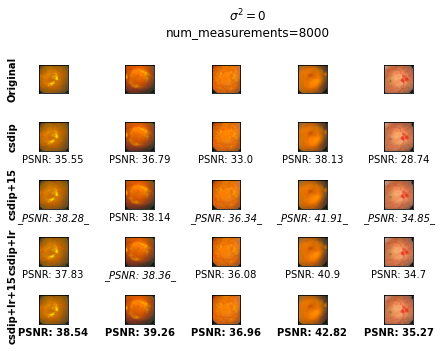

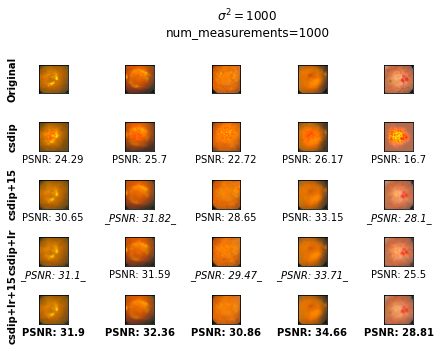

In [198]:
args = Args()
args.DATASET = 'retino' # 'mnist', 'xray', or 'retino' 
args.IMG_SIZE = 128
args.NUM_CHANNELS = 3
args.DEMO = 'True' 
args.path_root = "reconstructions"
args.ALG_LIST = ['csdip', 'csdip+lr', 'csdip+15', 'csdip+lr+15']
args.NUM_MEASUREMENTS_LIST = [1000, 4000, 8000]
args.VARIANCE_LIST = [0, 10, 100, 1000]
args = putils.construct_arg(args)

dataloader = utils.get_data(args) # get original images in PyTorch object
RECONSTRUCTIONS, METRICS = putils.get_plot_data(dataloader, args, old=False)

# easiest
var = np.min(args.VARIANCE_LIST)
n_meas = np.max(args.NUM_MEASUREMENTS_LIST)
qualitative_plot_ranked(dataloader, RECONSTRUCTIONS, METRICS, args, variance=var, num_measurements=n_meas)

# hardest
var = np.max(args.VARIANCE_LIST)
n_meas = np.min(args.NUM_MEASUREMENTS_LIST)
qualitative_plot_ranked(dataloader, RECONSTRUCTIONS, METRICS, args, variance=var, num_measurements=n_meas)

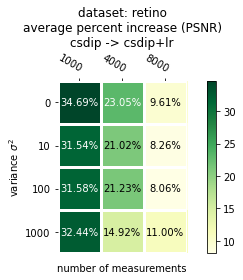

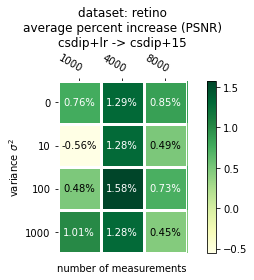

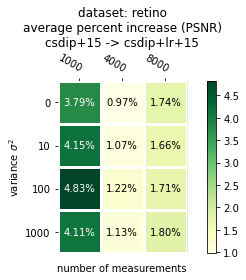

In [199]:
RECONSTRUCTIONS, METRICS = putils.get_plot_data(dataloader, args, old=False)

methods = ["csdip", "csdip+lr", "csdip+15", "csdip+lr+15"]

for i in range(len(methods)):
    if i == 0:
        continue
    plot_average_psnr_percent_increase(
        args,
        baseline=methods[i-1],
        experimental=methods[i]
    )

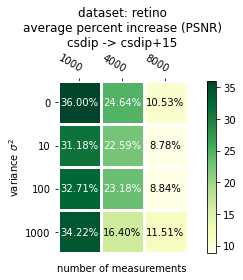

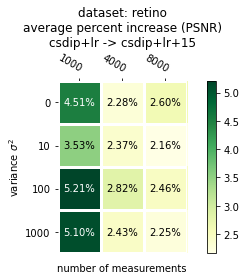

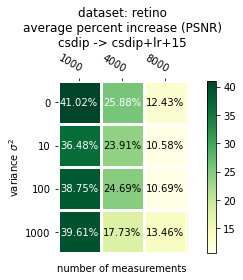

In [200]:
plot_average_psnr_percent_increase(
        args,
        baseline="csdip",
        experimental="csdip+15"
    )
plot_average_psnr_percent_increase(
        args,
        baseline="csdip+lr",
        experimental="csdip+lr+15"
    )
plot_average_psnr_percent_increase(
        args,
        baseline="csdip",
        experimental="csdip+lr+15"
    )

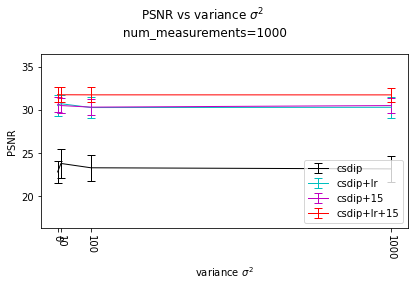

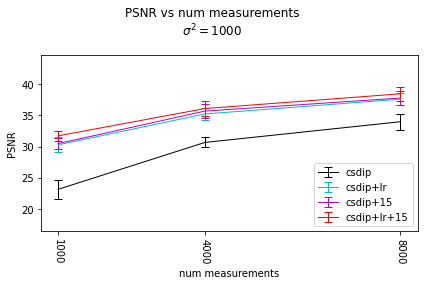

In [201]:
n_meas = 1000 # most compression
plot_metric_vs_variance(args, metric="PSNR", num_measurements=n_meas)

var = 1000 # most noise
plot_metric_vs_nmeas(args, metric="PSNR", variance=var)

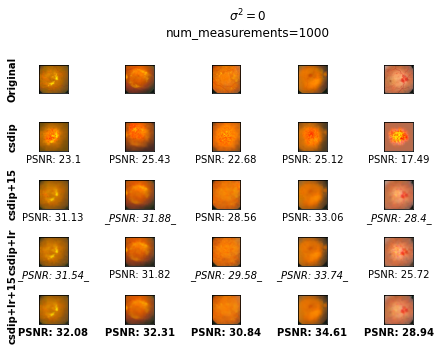

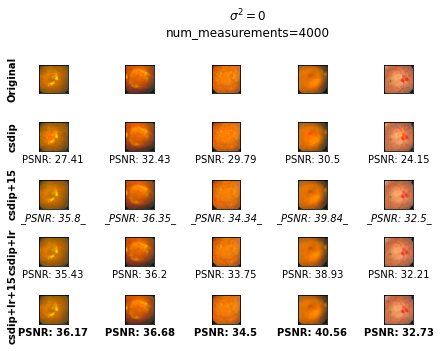

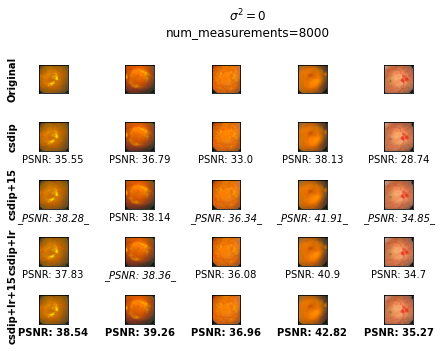

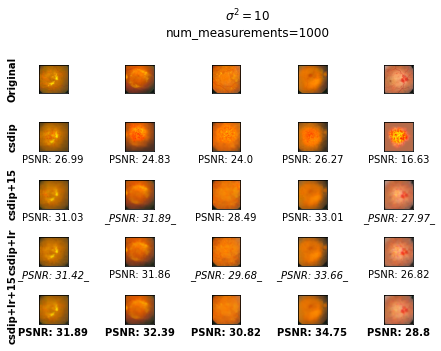

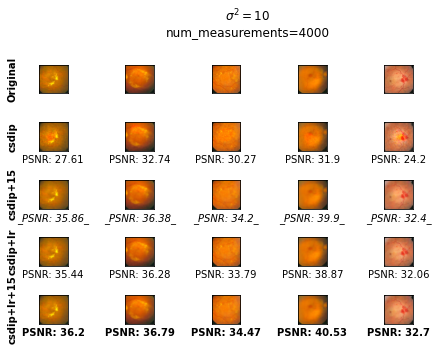

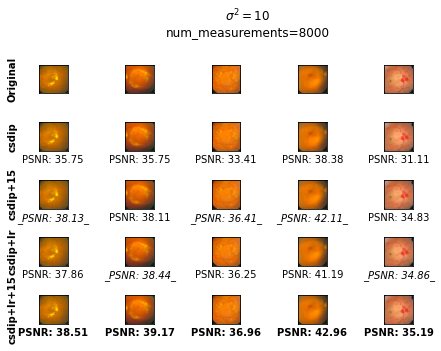

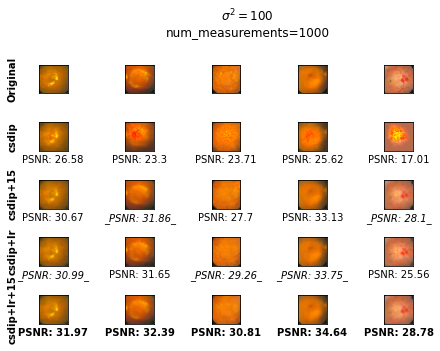

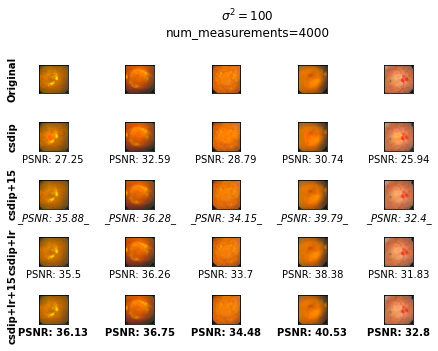

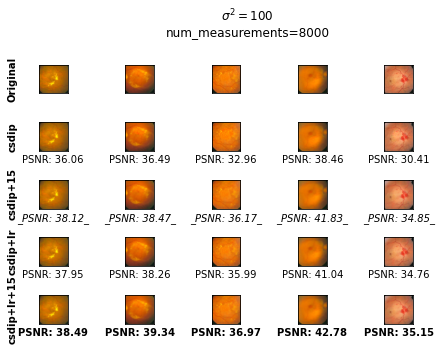

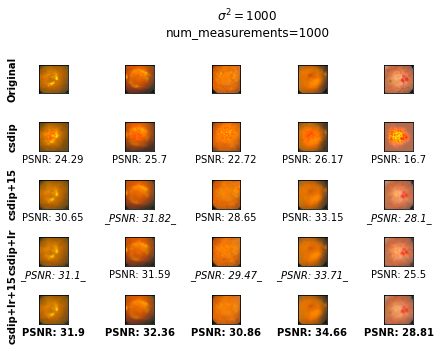

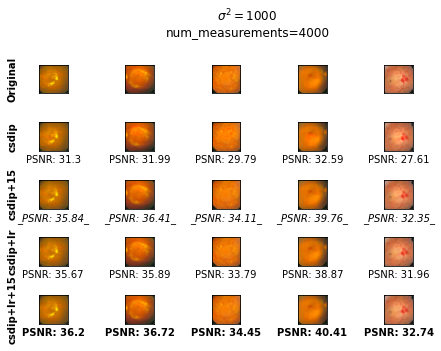

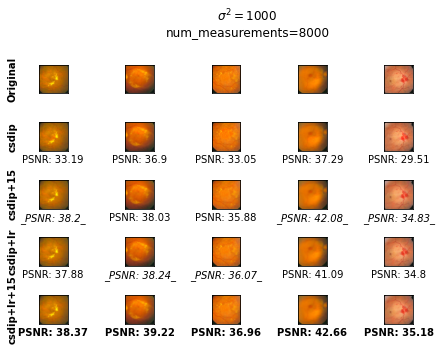

In [208]:
## for the appendix, save all reconstructions for retino dataset

for var in args.VARIANCE_LIST:
    for n_meas in args.NUM_MEASUREMENTS_LIST:
        qualitative_plot_ranked(dataloader, RECONSTRUCTIONS, METRICS, args, variance=var, num_measurements=n_meas, save_dpath="latex_files")

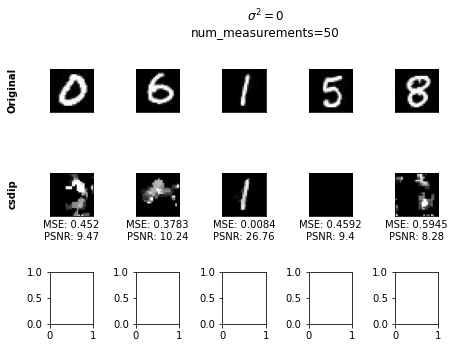

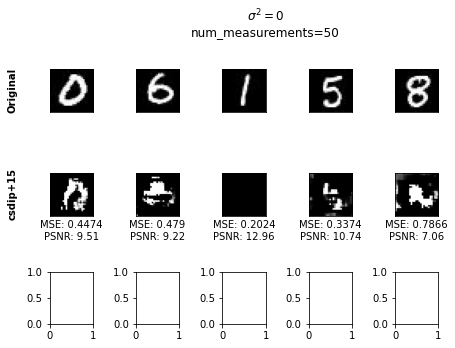

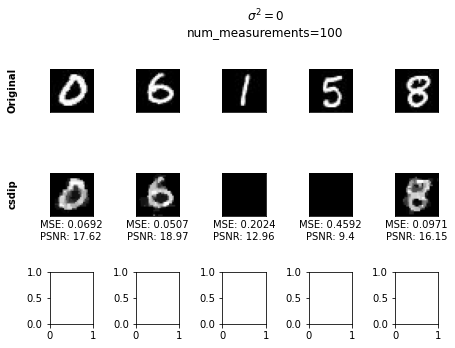

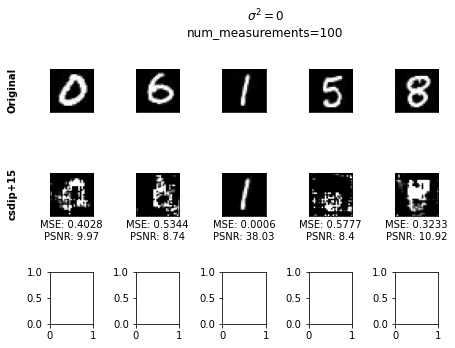

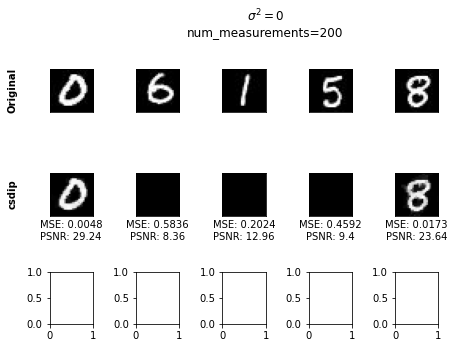

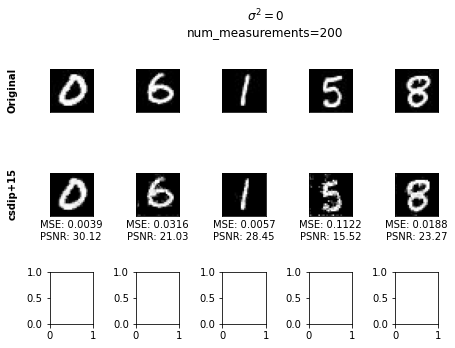

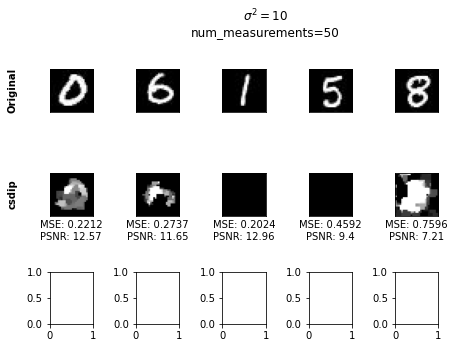

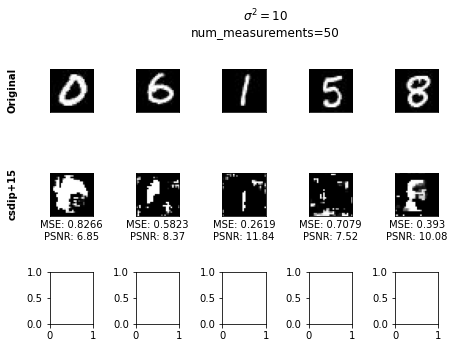

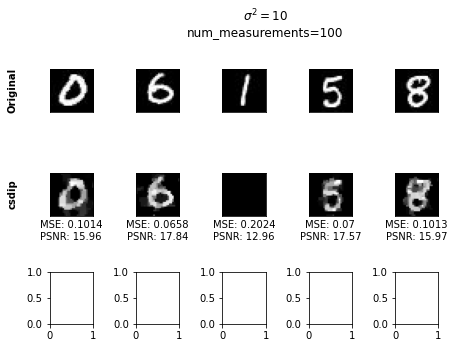

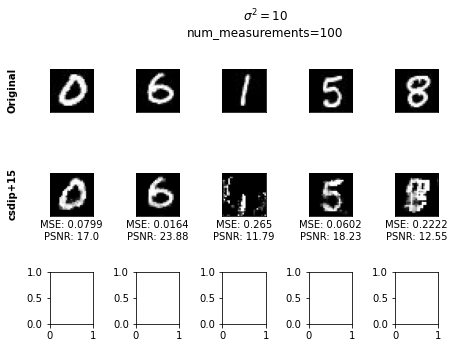

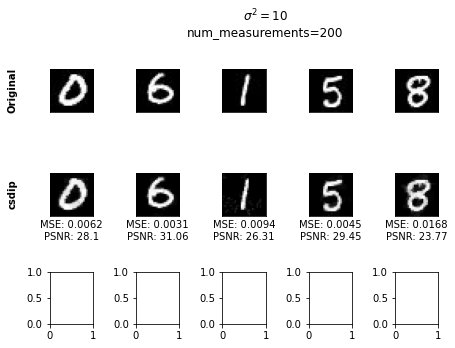

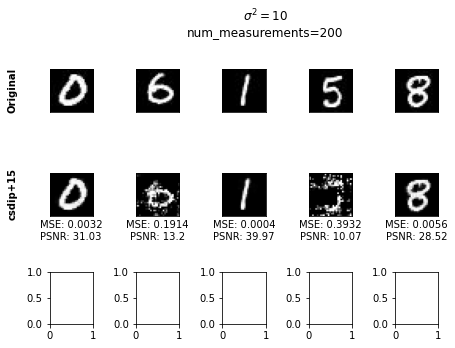

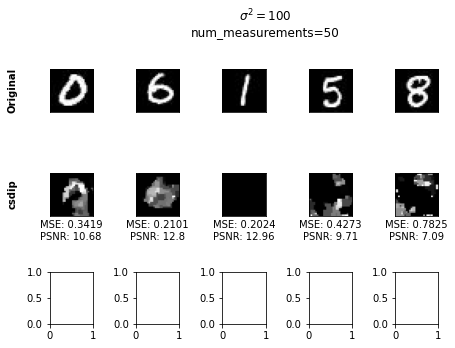

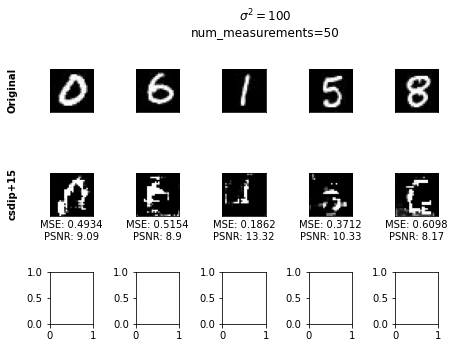

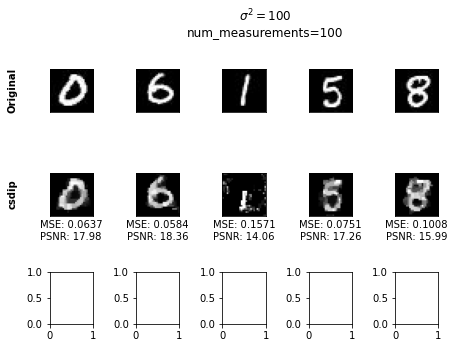

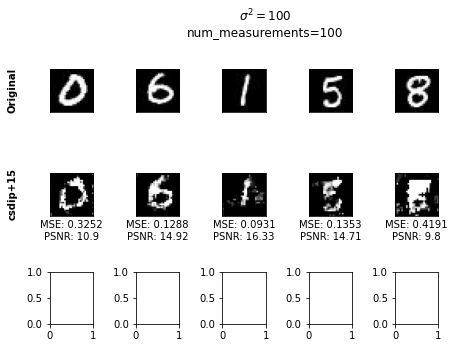

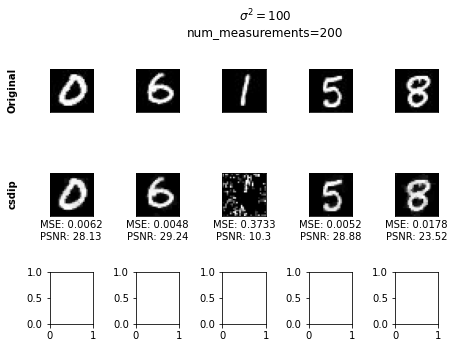

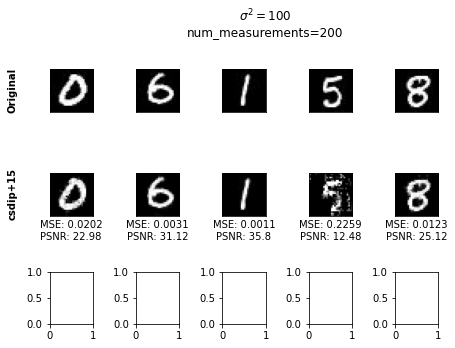

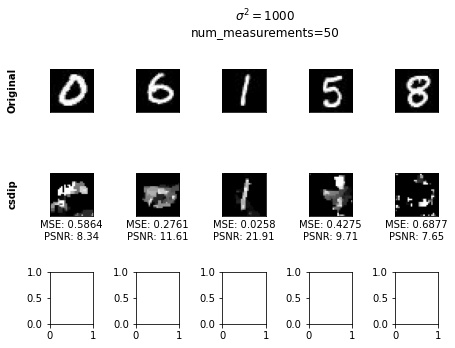

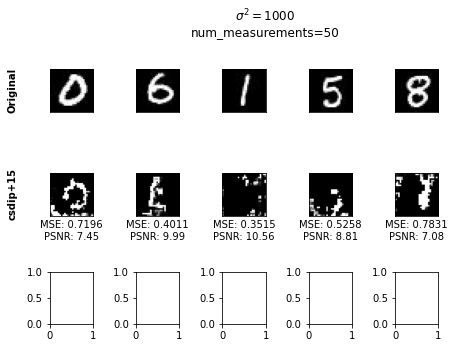

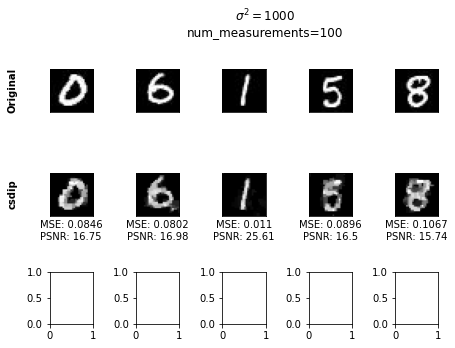

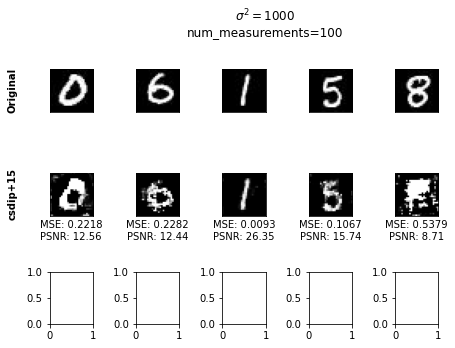

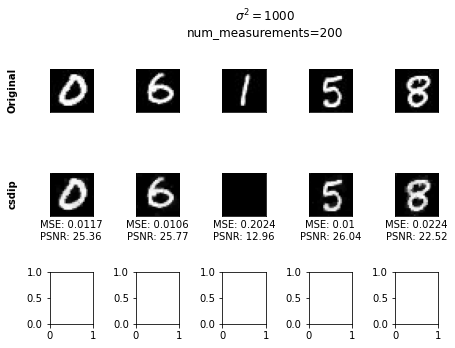

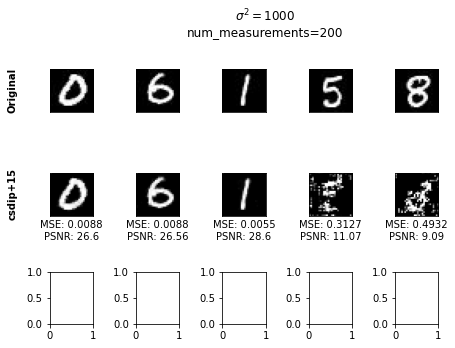

In [178]:
args.DATASET = 'mnist' # 'mnist', 'xray', or 'retino' 
args.DEMO = 'True' 
args.path_root = "reconstructions"#_good/"
args.ALG_LIST = ['csdip+15']#, 'csdip+10', 'csdip+100']
# args.ALG_LIST = ['csdip', 'csdip+100']
args.NUM_MEASUREMENTS_LIST = [50, 100, 200]# [10,25,35,50,75,100,200] # mnist
args.VARIANCE_LIST = [0, 10, 100, 1000]
args = putils.construct_arg(args)

dataloader = utils.get_data(args) # get original images in PyTorch object
RECONSTRUCTIONS, METRICS = putils.get_plot_data(dataloader, args, old=False)

args.path_root = "reconstructions_good/"
args.ALG_LIST = ['csdip']#, 'csdip+10', 'csdip+100']
dataloader_baseline = utils.get_data(args) # get original images in PyTorch object
RECONSTRUCTIONS_baseline, METRICS_baseline = putils.get_plot_data(dataloader_baseline, args, old=False)

# qualitative_plot(dataloader, RECONSTRUCTIONS, METRICS, args,
#                  variance=args.VARIANCE_LIST[0],
#                  num_measurements=args.NUM_MEASUREMENTS_LIST[0])

# plot_average_psnr_percent_increase(
#     args,
#     baseline="csdip",
#     experimental="csdip+10"
# )
# plot_average_psnr_percent_increase(
#     args,
#     baseline="csdip",
#     experimental="csdip+50"
# )
# plot_average_psnr_percent_increase(
#     args,
#     baseline="csdip",
#     experimental="csdip+100"
# )

# var = 1000
# n_meas = 200
for var in args.VARIANCE_LIST:
    for n_meas in args.NUM_MEASUREMENTS_LIST:
#         n_meas = 200
        qualitative_plot(dataloader_baseline, RECONSTRUCTIONS_baseline, METRICS_baseline, args, variance=var, num_measurements=n_meas)
        qualitative_plot(dataloader, RECONSTRUCTIONS, METRICS, args, variance=var, num_measurements=n_meas)
#         break
# var = 1000
# n_meas = 100
# qualitative_plot(dataloader, RECONSTRUCTIONS, METRICS, args, variance=var, num_measurements=n_meas)

# var = 1000
# plot_metric_vs_nmeas(args, metric="MSE", variance=var)
# plot_metric_vs_nmeas(args, metric="PSNR", variance=var)


# n_meas = 100
# plot_metric_vs_variance(args, metric="MSE", num_measurements=n_meas)
# plot_metric_vs_variance(args, metric="PSNR", num_measurements=n_meas)

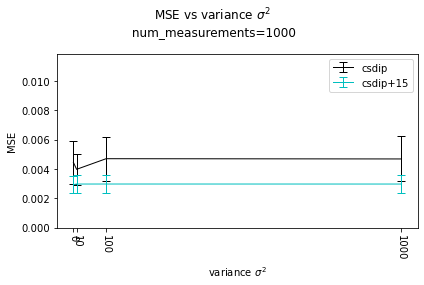

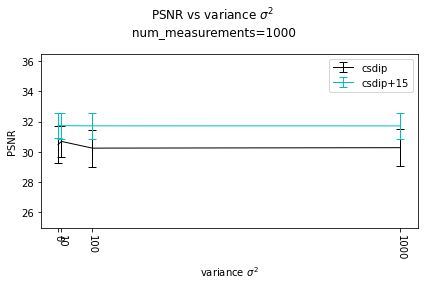

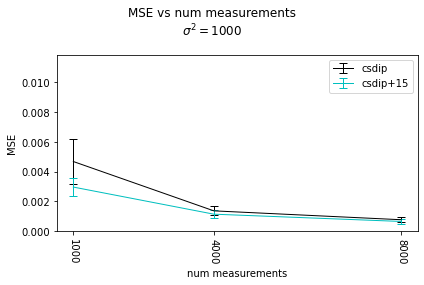

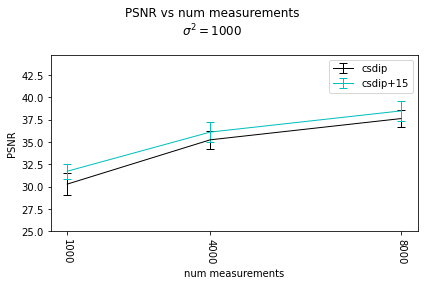

In [364]:
# n_meas = 1000 # most compression
# plot_metric_vs_variance(args, metric="MSE", num_measurements=n_meas)
# plot_metric_vs_variance(args, metric="PSNR", num_measurements=n_meas)

# var = 1000 # most noise
# plot_metric_vs_nmeas(args, metric="MSE", variance=var)
# plot_metric_vs_nmeas(args, metric="PSNR", variance=var)
    
# for var in args.VARIANCE_LIST:
#     for n_meas in args.NUM_MEASUREMENTS_LIST:
#         plot_metric_vs_nmeas(args, metric="MSE", variance=var)
#         plot_metric_vs_nmeas(args, metric="PSNR", variance=var)
        
# for var in args.VARIANCE_LIST:
#     for n_meas in args.NUM_MEASUREMENTS_LIST:
#         plot_metric_vs_variance(args, metric="MSE", num_measurements=n_meas)
#         plot_metric_vs_variance(args, metric="PSNR", num_measurements=n_meas)





# for var in args.VARIANCE_LIST:
# # for n_meas in args.NUM_MEASUREMENTS_LIST:
#     qualitative_plot(dataloader, RECONSTRUCTIONS, METRICS, args, variance=var, num_measurements=n_meas)
#     break

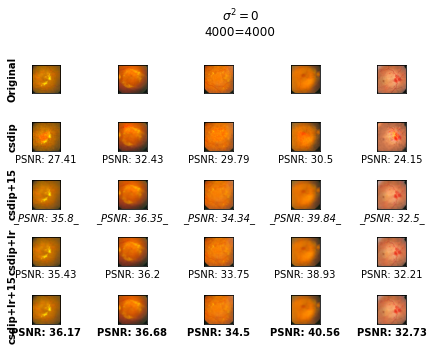

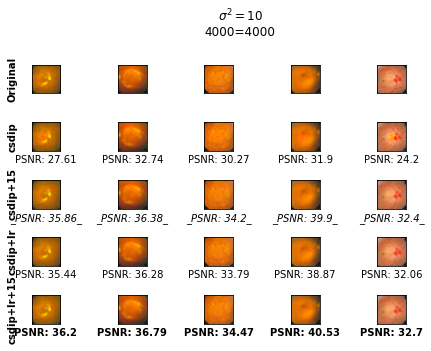

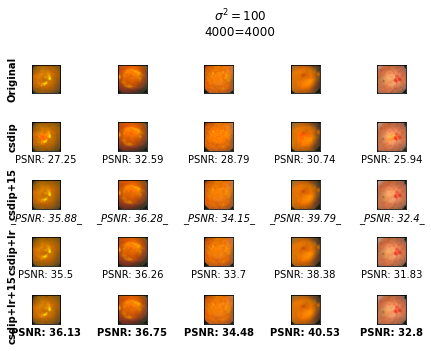

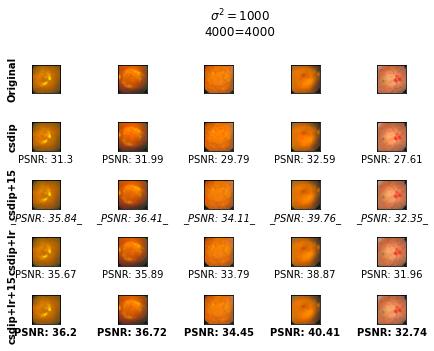

In [105]:
args.DATASET = 'retino' # 'mnist', 'xray', or 'retino' 
args.DEMO = 'True' 
args.path_root = "reconstructions"
args.ALG_LIST = ['csdip', 'csdip+lr', 'csdip+15', 'csdip+lr+15']
args.NUM_MEASUREMENTS_LIST = [1000, 4000, 8000]
args.VARIANCE_LIST = [0, 10, 100, 1000]
args = putils.construct_arg(args)

dataloader = utils.get_data(args) # get original images in PyTorch object
RECONSTRUCTIONS, METRICS = putils.get_plot_data(dataloader, args, old=False)

for var in args.VARIANCE_LIST:
    for n_meas in args.NUM_MEASUREMENTS_LIST:
        qualitative_plot(dataloader, RECONSTRUCTIONS, METRICS, args, variance=var, num_measurements=n_meas)


# args.path_root = "reconstructions"
# # args.ALG_LIST = ['csdip']#, 'csdip+10', 'csdip+100']
# dataloader_baseline = utils.get_data(args) # get original images in PyTorch object
# RECONSTRUCTIONS_baseline, METRICS_baseline = putils.get_plot_data(dataloader_baseline, args, old=False)

# qualitative_plot(dataloader, RECONSTRUCTIONS, METRICS, args,
#                  variance=args.VARIANCE_LIST[0],
#                  num_measurements=args.NUM_MEASUREMENTS_LIST[0])

# plot_average_psnr_percent_increase(
#     args,
#     baseline="csdip",
#     experimental="csdip+10"
# )
# plot_average_psnr_percent_increase(
#     args,
#     baseline="csdip",
#     experimental="csdip+50"
# )
# plot_average_psnr_percent_increase(
#     args,
#     baseline="csdip",
#     experimental="csdip+100"
# )

# var = 1000
# n_meas = 200
#         break
#     break
        # qualitative_plot(dataloader_baseline, RECONSTRUCTIONS_baseline, METRICS_baseline, args, variance=var, num_measurements=n_meas)
        
#         break
# var = 1000
# n_meas = 100
# qualitative_plot(dataloader, RECONSTRUCTIONS, METRICS, args, variance=var, num_measurements=n_meas)

# var = 1000
# plot_metric_vs_nmeas(args, metric="MSE", variance=var)
# plot_metric_vs_nmeas(args, metric="PSNR", variance=var)


# n_meas = 100
# plot_metric_vs_variance(args, metric="MSE", num_measurements=n_meas)
# plot_metric_vs_variance(args, metric="PSNR", num_measurements=n_meas)

<Figure size 432x288 with 0 Axes>

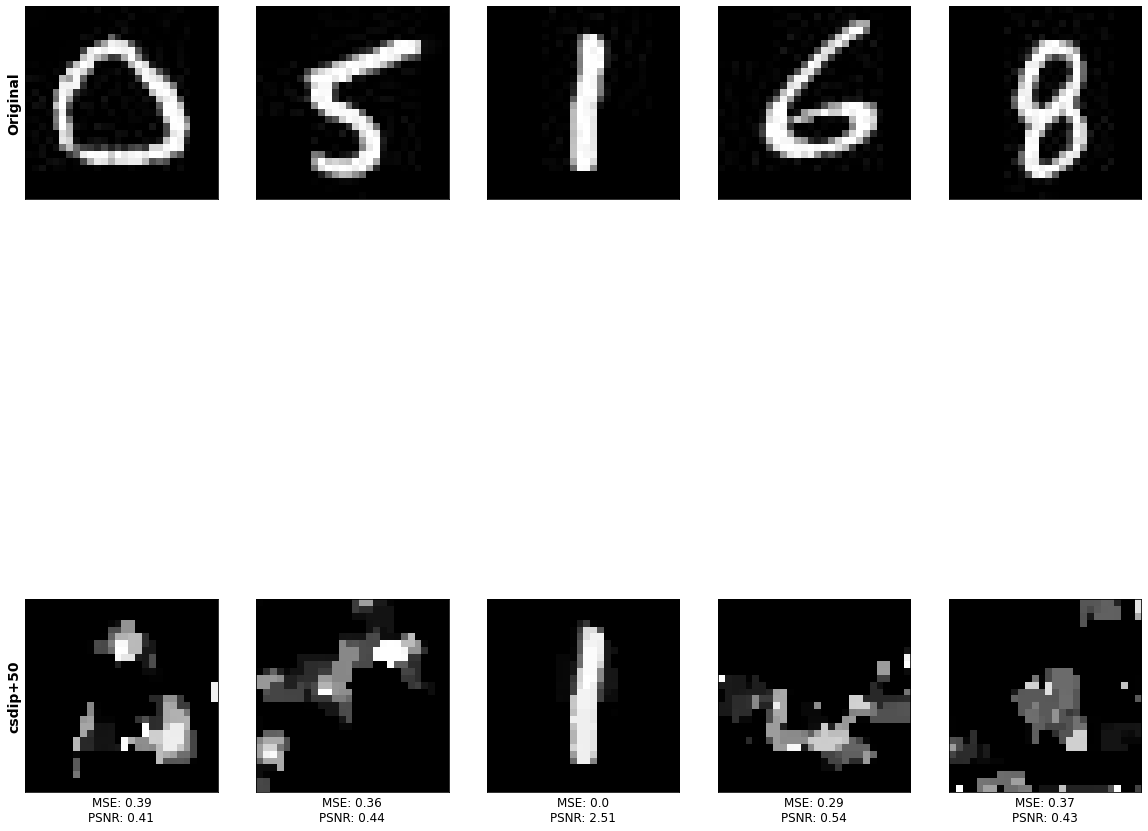

In [38]:
# var = 0
# n_meas = 50
# qualitative_plot(dataloader, RECONSTRUCTIONS, METRICS, args, variance=var, num_measurements=n_meas)

In [190]:
# args = Args() # create an argument class

# args.DATASET = 'mnist' # 'mnist', 'xray', or 'retino' 
# args.DEMO = 'True' # If 'True' run over 5 images for demo; else run over entire dataset
# args.NUM_MEASUREMENTS_LIST = [50, 100, 200]# [10,25,35,50,75,100,200] # mnist
# # args.NUM_MEASUREMENTS_LIST = [100]#,1000,2000,4000,8000] # xray or retino
# args.VARIANCE_LIST = [0, 10, 100, 1000]


# args.ALG_LIST = ['csdip', 'dct', 'wavelet']#,'bm3d','tval3','dct'] # choose which algorithms to plot
# args.ALG_LIST = ['csdip', 'csdip+10', 'csdip+50', 'csdip+100']#,'bm3d','tval3','dct'] # choose which algorithms to plot
# args.ALG_LIST = ['csdip+10', 'csdip+50']#,'bm3d','tval3','dct'] # choose which algorithms to plot

# args = putils.construct_arg(args)

# dataloader = utils.get_data(args) # get original images in PyTorch object

# # load reconstructions, compute mse
# args.path_root = "april9_results/reconstructions"
# args.ALG_LIST = ['csdip+50']
# args.NUM_MEASUREMENTS_LIST = [50]# [10,25,35,50,75,100,200] # mnist
# args.VARIANCE_LIST = [0]
# RECONSTRUCTIONS, METRICS = putils.get_plot_data(dataloader, args, old=False)

<Figure size 432x288 with 0 Axes>

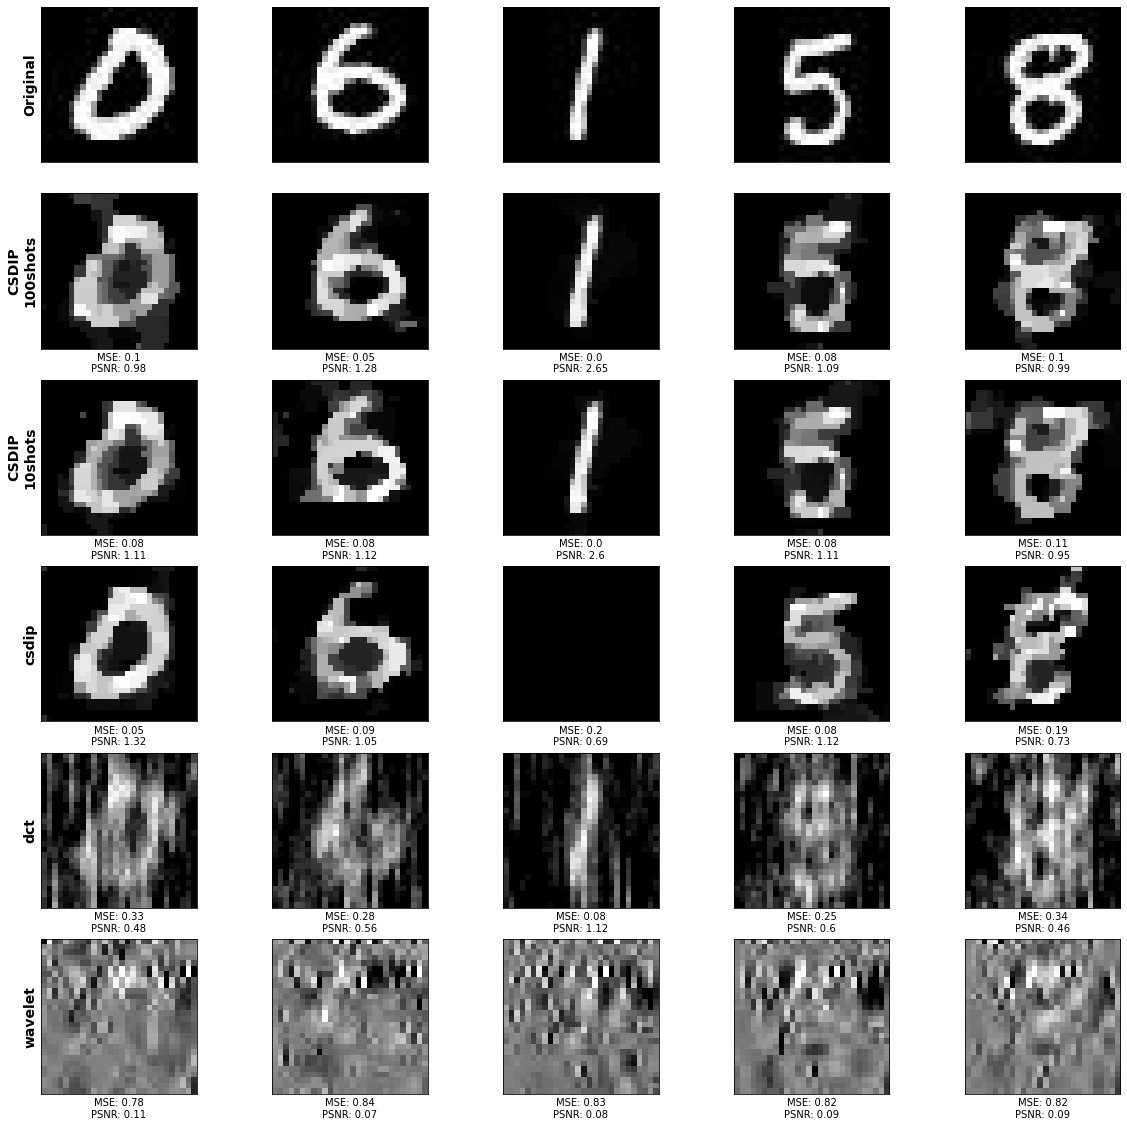

In [54]:
def rkan3_plot(dataloader, RECONSTRUCTIONS, METRICS, args, pargs):
    ## assume variance/num_measurements are fixed
    NROWS = len(RECONSTRUCTIONS) + 1 #+1 for original images
    NCOLS = len(dataloader)
    
    metrics_precision = 2
    
    plt.suptitle(pargs.get("title", "")) #should show variance, which is fixed for all measurements
    for NUM_MEASUREMENTS in args.NUM_MEASUREMENTS_LIST:
        fig, ax = plt.subplots(NROWS, NCOLS)
        fig.set_size_inches(20, 20, forward=True)
         
        ## Row 0: Original Images
        ax[0, 0].set_ylabel('Original', fontdict=dict(weight='bold', size=14))
        for k, (batch, _ , im_path) in enumerate(dataloader):
            putils.plot_image(batch, args, flag='orig', axis_dict=dict(axis=ax[0,k], label=None))
            
        ## Row 1 - Row num_algorithms: each algorithm
        for i, ALG in enumerate(sorted(RECONSTRUCTIONS)):
            args.ALG = ALG
            ax[i+1, 0].set_ylabel(ALG, fontdict=dict(weight='bold', size=14))
            for k, image in enumerate(RECONSTRUCTIONS[ALG][NUM_MEASUREMENTS]):
                mse = round(METRICS['MSE'][ALG][NUM_MEASUREMENTS][k], metrics_precision)
                psnr = round(METRICS['PSNR'][ALG][NUM_MEASUREMENTS][k], metrics_precision)
                label = f"MSE: {mse}\nPSNR: {psnr}"
                putils.plot_image(image, args, flag='recons', axis_dict=dict(axis=ax[i+1,k], label=label))

var = 0
n_meas = 50
pargs = {
    "title": f"$\sigma^2={var}$\nnum_measurements={n_meas}"
}
qualitative_plot(dataloader, RECONSTRUCTIONS, METRICS, args, pargs)

{'csdip': {'fmt': 'r-', 'label': 'csdip', 'markersize': 7, 'capsize': 4.0, 'linewidth': 1, 'elinewidth': 1}, 'dct': {'fmt': 'g-', 'label': 'Lasso-DCT', 'markersize': 7, 'capsize': 4.0, 'linewidth': 1, 'elinewidth': 1, 'markerfacecolor': 'None'}, 'wavelet': {'fmt': 'b-', 'label': 'Lasso-DB4', 'markersize': 7, 'capsize': 4.0, 'linewidth': 1, 'elinewidth': 1, 'markerfacecolor': 'None'}, 'bm3d': {'fmt': 'o-', 'label': 'BM3D-AMP', 'markersize': 7, 'capsize': 4.0, 'linewidth': 1, 'elinewidth': 1, 'markerfacecolor': 'None'}, 'tval3': {'fmt': 'v-', 'label': 'TVAL3', 'markersize': 7, 'capsize': 4.0, 'linewidth': 1, 'elinewidth': 1, 'markerfacecolor': 'None'}, 'csdip+pretraining': {'fmt': 'c-', 'label': 'csdip+pretraining', 'markersize': 7, 'capsize': 4.0, 'linewidth': 1, 'elinewidth': 1}}


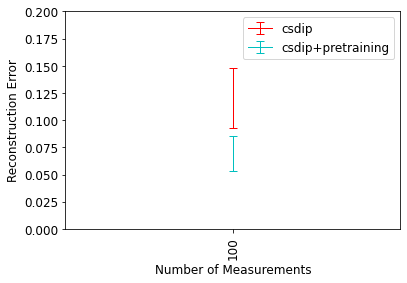

In [127]:
import copy
baseline = {100: [0.048087084641055676,
   0.08901126820009503,
   0.20238707529336242,
   0.07600266731364287,
   0.18535926615235732]}
pretraining = {100: [0.07739324620223519,
   0.07670043516442718,
   0.0025033098857245814,
   0.07688068865281986,
   0.11345220316150442]}
dictionary = {
    "csdip": baseline,
    "csdip+pretraining": pretraining
}

# sns.set_style('darkgrid')
matplotlib.rc('font', size=12)
KWARGS_DICT = putils.set_kwargs()

for k in dictionary:
    KWARGS_DICT[k] = copy.deepcopy(KWARGS_DICT[k])
# KWARGS_DICT["csdip+pretraining"]["fmt"] = "o-"
# KWARGS_DICT["csdip+pretraining"]["label"] = "csdip+pretraining"

# KWARGS_DICT["csdip"]["fmt"] = "v-"
# KWARGS_DICT["csdip"]["label"] = "csdip"

print(KWARGS_DICT)

# Plot MSE of each algorithm
for ALG in dictionary:
    kwargs = KWARGS_DICT[ALG]
#     kwargs["fmt"] = "o-"
    putils.plot_mse(dictionary[ALG], args, kwargs)

Y_LIM = 0.005 # set max value on vertical axis 
Y_LIM = 0.1 # set max value on vertical axis 
Y_LIM = 0.2
putils.plot_format(Y_LIM, args) # set labels, limits, ticks, legend in plot

plt.show()

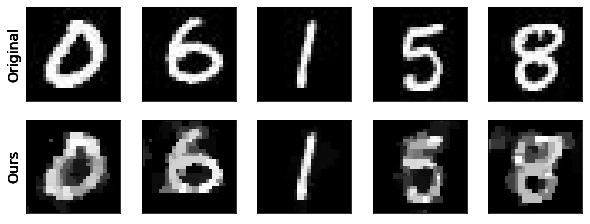

In [91]:
FIG_HEIGHT = 5
NUM_PLOT = len(dataloader)

for NUM_MEASUREMENTS in args.NUM_MEASUREMENTS_LIST:
    fig = plt.figure(figsize=[2* NUM_PLOT, 2* FIG_HEIGHT])
    outer_counter = 0
    inner_counter = 0

    # Diplay original images
    outer_counter += 1
    for k, (batch, _ , im_path) in enumerate(dataloader):
        if k not in range(NUM_PLOT):
            continue
        inner_counter += 1

        ax = fig.add_subplot(FIG_HEIGHT, 1, outer_counter, frameon=False)
        putils.set_axes('Original', ax)  
        _ = fig.add_subplot(FIG_HEIGHT, NUM_PLOT, inner_counter)
        putils.plot_image(batch, args, flag='orig')
    
    # Display reconstructions
    for i,ALG in enumerate(args.ALG_LIST):
        args.ALG = ALG
        outer_counter += 1
        for k, image in enumerate(RECONSTRUCTIONS[ALG][NUM_MEASUREMENTS]):
            if k not in range(NUM_PLOT):
                continue
            inner_counter += 1
            
            ax = fig.add_subplot(FIG_HEIGHT, 1, outer_counter, frameon=False)
            putils.set_axes(KWARGS_DICT[ALG]['label'], ax)
            _ = fig.add_subplot(FIG_HEIGHT, NUM_PLOT, inner_counter)
            putils.plot_image(image, args, flag='recons')

In [86]:
MSE

{'csdip': {100: [0.7499619525734237,
   0.2003970105116622,
   0.20238707529336242,
   0.38900628072395277,
   0.4390308008928198]}}

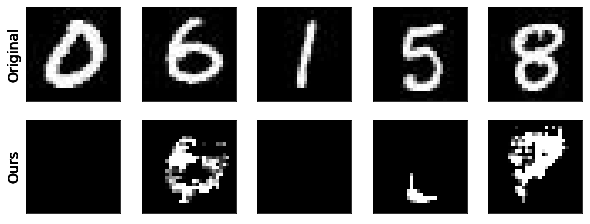

In [87]:
FIG_HEIGHT = 5
NUM_PLOT = len(dataloader)

for NUM_MEASUREMENTS in args.NUM_MEASUREMENTS_LIST:
    fig = plt.figure(figsize=[2* NUM_PLOT, 2* FIG_HEIGHT])
    outer_counter = 0
    inner_counter = 0

    # Diplay original images
    outer_counter += 1
    for k, (batch, _ , im_path) in enumerate(dataloader):
        if k not in range(NUM_PLOT):
            continue
        inner_counter += 1

        ax = fig.add_subplot(FIG_HEIGHT, 1, outer_counter, frameon=False)
        putils.set_axes('Original', ax)  
        _ = fig.add_subplot(FIG_HEIGHT, NUM_PLOT, inner_counter)
        putils.plot_image(batch, args, flag='orig')
    
    # Display reconstructions
    for i,ALG in enumerate(args.ALG_LIST):
        args.ALG = ALG
        outer_counter += 1
        for k, image in enumerate(RECONSTRUCTIONS[ALG][NUM_MEASUREMENTS]):
            if k not in range(NUM_PLOT):
                continue
            inner_counter += 1
            
            ax = fig.add_subplot(FIG_HEIGHT, 1, outer_counter, frameon=False)
            putils.set_axes(KWARGS_DICT[ALG]['label'], ax)
            _ = fig.add_subplot(FIG_HEIGHT, NUM_PLOT, inner_counter)
            putils.plot_image(image, args, flag='recons')

In [73]:
MSE

{'csdip': {100: [0.10527848972606037,
   0.5836177669889315,
   0.20238707529336242,
   0.45919262454212184,
   0.4867297990546485]}}

In [61]:
MSE

{'csdip': {100: [0.048087084641055676,
   0.08901126820009503,
   0.20238707529336242,
   0.07600266731364287,
   0.18535926615235732]},
 'dct': {100: [0.32982270469151703,
   0.2764358222595492,
   0.07591939819402979,
   0.25091908984815564,
   0.343586000972054]},
 'wavelet': {100: [0.7788227437597484,
   0.8419377345999532,
   0.8336747439086605,
   0.8169554248375404,
   0.8166058615817556]}}